In [2]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
DATASET_DIR = 'dataset/news_dataset.csv'
SAVE_MODEL_DIR = 'models/phobert_svm_model'


In [3]:
# ================== TRAIN & LƯU MODEL ==================
from phobert_svm_pipeline import train_phobert_svm

# Train từ CSV (dùng title + content + topic) và lưu toàn bộ artifacts vào SAVE_MODEL_DIR
clf, le, X_test_txt, y_test = train_phobert_svm(
    DATASET_DIR,
    save_dir=SAVE_MODEL_DIR
)


Run on: cuda
>> Embedding train set...
>> Embedding test set...
>> Training SVM...
>> Evaluation:
                      precision    recall  f1-score   support

           chính trị       0.67      0.82      0.73       757
           công nghệ       0.77      0.84      0.81       757
            giáo dục       0.78      0.83      0.81       757
kinh doanh tài chính       0.60      0.51      0.55       758
             kinh tế       0.55      0.56      0.56       757
           pháp luật       0.72      0.90      0.80       757
   sức khỏe đời sống       0.65      0.67      0.66       758
            thế giới       0.78      0.87      0.82       757
            thể thao       0.96      0.98      0.97       757
             thời sự       0.53      0.29      0.37       757
    văn hóa giải trí       0.75      0.78      0.77       758
                  xe       0.84      0.94      0.88       757
              xã hội       0.56      0.36      0.44       757

            accuracy            

In [4]:
# ================== LOAD MODEL & DỰ ĐOÁN ==================
from phobert_svm_pipeline import load_model, predict_topic

# Load lại model từ SAVE_MODEL_DIR
clf, le = load_model(SAVE_MODEL_DIR)

# Dự đoán thử
topic = predict_topic(
    "Mở rộng diện lãnh đạo chủ chốt của Đảng, Nhà nước",
    "Lãnh đạo chủ chốt của Đảng, Nhà nước gồm 5 chức danh Tổng Bí thư, Chủ tịch nước, Thủ tướng, Chủ tịch Quốc hội, Thường trực Ban Bí thư. Bộ Chính trị ngày 8/9 ban hành quy định danh mục vị trí chức danh, nhóm chức danh, chức vụ lãnh đạo của hệ thống chính trị. 5 chức danh lãnh đạo chủ chốt của Đảng, Nhà nước gồm: Tổng Bí thư, Chủ tịch nước, Thủ tướng, Chủ tịch Quốc hội, Thường trực Ban Bí thư. So với quy định năm 2022, chức danh Thường trực Ban Bí thư chuyển từ nhóm lãnh đạo cấp cao lên lãnh đạo chủ chốt.",
    clf, le
)
print("Predicted topic:", topic)

Predicted topic: xã hội


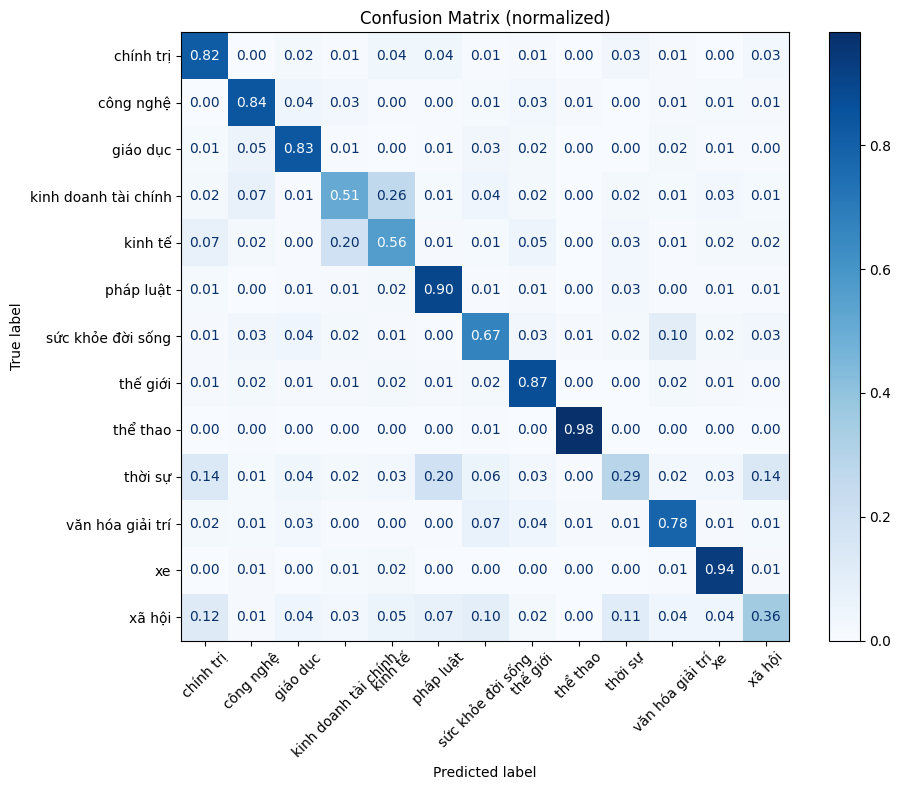

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


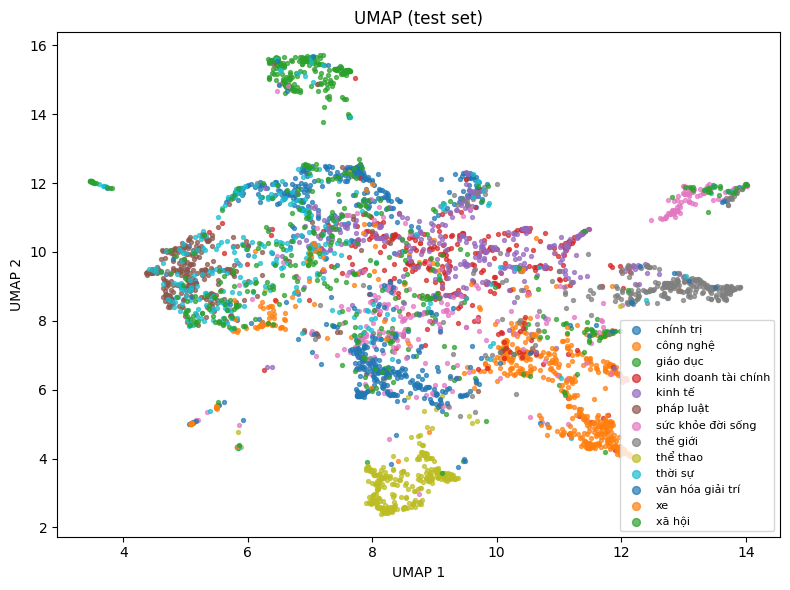

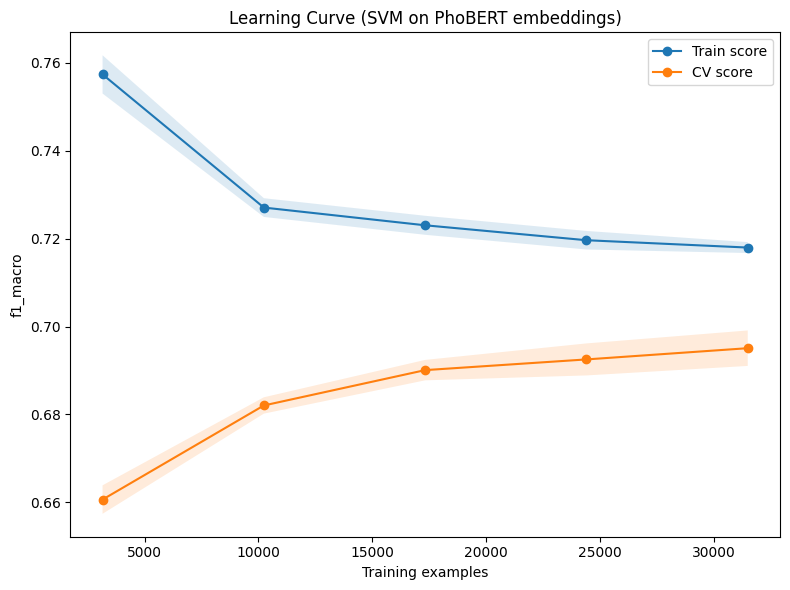

In [5]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA ==================
from phobert_svm_pipeline import (
    load_test_set, load_embeddings,
    evaluate_confusion_matrix, plot_umap_embeddings, plot_learning_curve_svm
)

# Dùng đúng SAVE_MODEL_DIR đã cấu hình
X_test_txt, y_test = load_test_set(SAVE_MODEL_DIR)
X_train, y_train, X_test, y_test_num = load_embeddings(SAVE_MODEL_DIR)

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf, le,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    le=le,
    title="UMAP (test set)"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro"
)
